In [18]:
# model_XGBoost.ipynb

# This script can be run on local machine (CPU) or Google Colab (GPU)
# Several options of a XGBoost model are available and have to be uncommented, when they should be used. 

# Model XGBoost with "Early Stopping" using XGBClassifier needs an additional validation set in order to perform the early stopping. 
# This validation set is created by splitting the train-set into 20% validation and 80% training.


# XGBoost model

In [19]:
# set "machine" according to where you want to run the script
# option 'colab' uses a GPU
# option 'local' uses a CPU

machine = 'local' # 'colab' or 'local'

## import libs

In [20]:
import numpy as np
import pandas as pd
import os

import joblib

from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier

#rom sklearn.preprocessing import StandardScaler
#from sklearn.svm import SVC, LinearSVC

if machine == 'colab':
  !pip install Scikit-Optimize

# For hyperparamter testing
#from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# For classification performance metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# for visualization:
import seaborn as sns
import matplotlib.pyplot as plt



# lib for accelreation sklearn on GPU (google colab)
#if machine == 'colab':
#    %load_ext cuml.accel
#    import sklearn

In [21]:
# load google drive when working on colab
if machine == 'colab':
    from google.colab import drive
    #drive.mount('/content/drive')
    drive.mount("/content/drive", force_remount=True)

## definitions to set by user to run the script:

In [22]:
#####################################
# options for usable datasets:
#####################################

list_datasets = ['128_nomask', '128_mask', 'hog', '20_mask', '128_no_aug_mask', '128_no_aug_nomask']

# list_datasets[0] = '128_nomask'
# list_datasets[1] = '128_mask'
# list_datasets[2] = 'hog'
# list_datasets[3] = '20_mask'
# list_datasets[4] = '128_no_aug_mask'   (images 128 x 128, non augmented, with mask, in each class train: 1000 images, test: 269 images)
# list_datasets[5] = '128_no_aug_nomask' (images 128 x 128, non augmented, without mask, in each class train: 1000 images, test: 269 images)

# # choose one dataset by setting the number of element of list_datasets:
flag_dataset = list_datasets[2]

print(flag_dataset)

#####################################
# options to resplit the trainig-set 
# into train and validation set:
#####################################

flag_valid_set = True


#####################################
# options to run on local computer:
#####################################

# set the following paramter = True when you run the script on local comupter. 
# This means a smaller dataset with less images will be used. 

flag_slicing = False    # True or False
num_subset = 1000   # number of iamges of each class to use. parameter is only used when run_local = True


#####################################
# paths:
#####################################

if machine == 'local':
    # paths to load data:
    base_path = r"..\\data\\"
    base_path_in = os.path.join(base_path, "processed")   # path to read from the *.npy files

    # paths to save models:
    model_path = r"..\\Models\\local\\ML"

elif machine == 'colab':
    # paths to load data:
    base_path = '/content/drive/MyDrive/data'
    base_path_in = os.path.join(base_path, "processed")   # path to read from the *.npy files

    # paths to save models:
    model_path = '/content/drive/MyDrive/models/local/ML'

hog


## functions

In [23]:
def create_cm(y_test, y_pred, flag_norm, model_path, model_name):
    
    if not (flag_norm is None):
        print("norma")
        print(flag_norm)
        cm_file     = os.path.join(model_path, "results", model_name + "_cm_norm.png")
        format_anot = '.2f'
    else:
        print("abs")
        print(flag_norm)
        cm_file     = os.path.join(model_path, "results", model_name + "_cm_abs.png")
        format_anot = 'd'

    cm = confusion_matrix(y_test, y_pred, normalize=flag_norm)

    list_labels_enc = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

    plt.figure(figsize=(7,7))
    sns.heatmap(cm, cmap='Blues', cbar=False, annot=True, fmt=format_anot, xticklabels=list_labels_enc, yticklabels=list_labels_enc)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    
    plt.savefig(cm_file, format='png')
    plt.show()

## loading images

### images resized to 128 * 128, normalized, without masks

In [24]:
if flag_dataset == '128_nomask':

    train_npy_file = 'train_data_resized_without_masks_128_128.npz'
    test_npy_file  = 'test_data_resized_without_masks_128_128.npz'

    #train data
    train = np.load(os.path.join(base_path_in, train_npy_file), allow_pickle=True)
    X_train = train['X_train']
    y_train = train['y_train']

    # test data
    test = np.load(os.path.join(base_path_in, test_npy_file), allow_pickle=True)
    X_test = test['X_test']
    y_test = test['y_test']


### images resized to 128 * 128, normalized, with masks (incl. Gaussian Blur, Clahe)

In [25]:
if flag_dataset == '128_mask':
    
    train_npy_file = 'train_data_resized_with_masks_128_128.npz'
    test_npy_file  = 'test_data_resized_with_masks_128_128.npz'

    #train data
    train = np.load(os.path.join(base_path_in, train_npy_file), allow_pickle=True)
    X_train = train['X_train']
    y_train = train['y_train']

    # test data
    test = np.load(os.path.join(base_path_in, test_npy_file), allow_pickle=True)
    X_test = test['X_test']
    y_test = test['y_test']

### images resized to 20 * 20, normalized, with masks (incl. Gaussian Blur, Clahe)

In [26]:
if flag_dataset == '20_mask':
    
    train_npy_file = 'train_data_resized_with_masks_20_20.npz'
    test_npy_file  = 'test_data_resized_with_masks_20_20.npz'

    #train data
    train = np.load(os.path.join(base_path_in, train_npy_file), allow_pickle=True)
    X_train = train['X_train']
    y_train = train['y_train']

    # test data
    test = np.load(os.path.join(base_path_in, test_npy_file), allow_pickle=True)
    X_test = test['X_test']
    y_test = test['y_test']

### feature extraction with HOG based on images original size 299 * 299, normalized, with masks (incl. Gaussian Blur, Clahe) and apllied masks

In [27]:
if flag_dataset == 'hog':
    if machine  == 'local':
        base_path_in = os.path.join(base_path_in, "extracted")  # hog-files are in subfolder "extracted"

    train_npy_file = 'hog_features.npy'
    test_npy_file  = 'hog_features_test.npy'

    train_labels_file = 'labels_train.npy'
    test_labels_file = 'labels_test.npy'

    #train data
    X_train = np.load(os.path.join(base_path_in, train_npy_file))
    y_train = np.load(os.path.join(base_path_in, train_labels_file))

    # test data
    X_test = np.load(os.path.join(base_path_in, test_npy_file))
    y_test = np.load(os.path.join(base_path_in, test_labels_file))


### images resized to 128 * 128, normalized, with masks (incl. Gaussian Blur, Clahe) - non augmented (train: 1000 images, test: 269 images)

In [28]:
if flag_dataset == '128_no_aug_mask':
    
    train_npy_file = 'train_non_augmented_with_masks_resized_128_128.npz'
    test_npy_file  = 'test_non_augmented_with_masks_resized_128_128.npz'

    #train data
    train = np.load(os.path.join(base_path_in, train_npy_file), allow_pickle=True)
    X_train = train['X_train']
    y_train = train['y_train']

    # test data
    test = np.load(os.path.join(base_path_in, test_npy_file), allow_pickle=True)
    X_test = test['X_test']
    y_test = test['y_test']

### images resized to 128 * 128, normalized, without masks (incl. Gaussian Blur, Clahe) - non augmented (train: 1000 images, test: 269 images)

In [29]:
if flag_dataset == '128_no_aug_nomask':
    
    train_npy_file = 'train_non_augmented_without_masks_resized_128_128.npz'
    test_npy_file  = 'test_non_augmented_without_masks_resized_128_128.npz'

    #train data
    train = np.load(os.path.join(base_path_in, train_npy_file), allow_pickle=True)
    X_train = train['X_train']
    y_train = train['y_train']

    # test data
    test = np.load(os.path.join(base_path_in, test_npy_file), allow_pickle=True)
    X_test = test['X_test']
    y_test = test['y_test']

### print summary of loaded dataset

In [30]:
# print used datasets: 
print("------------------")
print("used datasets:")
print("train: ", train_npy_file)
print("test: ", test_npy_file)

------------------
used datasets:
train:  hog_features.npy
test:  hog_features_test.npy


### optional splitting the train set into: train & validation

In [31]:
if flag_valid_set == True:
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

### optional slicing to use less images for running on local machine

In [32]:
if flag_slicing  == True:
    print(X_train.shape)
    print(y_train.shape)
    df_X_train = pd.DataFrame(X_train)
    df_y_train = pd.DataFrame(y_train)
    df_y_train.rename(columns={0:'label'}, inplace=True)
    df_temp = pd.concat([df_X_train, df_y_train], axis=1)

    print(df_y_train.columns)

    
    df_temp_0 = df_temp[(df_temp.iloc[:,-1]==0)].iloc[0:num_subset,]
    df_temp_1 = df_temp[(df_temp.iloc[:,-1]==1)].iloc[0:num_subset,]
    df_temp_2 = df_temp[(df_temp.iloc[:,-1]==2)].iloc[0:num_subset,]
    df_temp_3 = df_temp[(df_temp.iloc[:,-1]==3)].iloc[0:num_subset,]

    df_temp_subset = pd.concat([df_temp_0, df_temp_1, df_temp_2, df_temp_3], axis=0)

    #df_temp_subset.iloc[:,-1].value_counts()

    df_X_train_subset = df_temp_subset.drop(['label'], axis=1)
    #df_X_train_subset = df_temp_subset.drop(df_temp_subset.iloc[:,-1:], axis=1)
    df_y_train_subset = df_temp_subset.iloc[:,-1]

    X_train = df_X_train_subset.to_numpy()
    y_train = df_y_train_subset.to_numpy()

    print("y_train: ", (y_train.shape))
    print("X_train: ", (X_train.shape))

In [33]:
# print length of datasets:
print("------------------")
print("Length of: ")
print("y_train: ", y_train.shape)
print("X_train: ", X_train.shape)

print("y_test: ", y_test.shape)
print("X_test: ",X_test.shape)

if flag_valid_set == True:
    print("y_valid: ", y_valid.shape)
    print("X_valid: ",X_valid.shape)


------------------
Length of: 
y_train:  (28047,)
X_train:  (28047, 8100)
y_test:  (4233,)
X_test:  (4233, 8100)
y_valid:  (7012,)
X_valid:  (7012, 8100)


## modelling

### creating matrices because XGBoost does not work with pandas DF

In [34]:
# # Create classification matrices
# m_train = xgb.DMatrix(data=X_train, label=y_train)
# m_test = xgb.DMatrix(data=X_test, label=y_test)

## XGBoost normal

In [35]:
# # Define hyperparameters

# if machine == 'colab':
#     params = {'booster': 'gbtree', "objective": "multi:softprob", "learning_rate": 0.3, "tree_method": "gpu_hist", "num_class":4} # with gpu
# elif machine == 'local':
#     params = {'booster': 'gbtree', "objective": "multi:softprob", "learning_rate": 0.3, "tree_method": "hist", "num_class":4} # with cpu

# n = 100

# model = xgb.train(
#    params=params,
#    dtrain=m_train,
#    num_boost_round=n,
# )

In [36]:
# # prediction
# preds = model.predict(m_test)

## XGBoost using validation sets during training

In [37]:
# # Using Validation Sets During Training

# if machine == 'colab':
#     params = {'booster': 'gbtree', "objective": "multi:softprob", "learning_rate": 0.3, "tree_method": "gpu_hist", "num_class":4} # with gpu
# elif machine == 'local':
#     params = {'booster': 'gbtree', "objective": "multi:softprob", "learning_rate": 0.3, "tree_method": "hist", "num_class":4} # with cpu

# n = 100

# evals = [(m_train, "train"), (m_test, "validation")]

# model = xgb.train(
#    params=params,
#    dtrain=m_train,
#    num_boost_round=n,
#    evals=evals,
#    verbose_eval=10 # Every ten rounds
# )

## XGBoost Early Stopping

In [38]:
# if machine == 'colab':
#     params = {'booster': 'gbtree', "objective": "multi:softprob", "learning_rate": 0.3, "tree_method": "gpu_hist", "num_class":4} # with gpu
# elif machine == 'local':
#     params = {'booster': 'gbtree', "objective": "multi:softprob", "learning_rate": 0.3, "tree_method": "hist", "num_class":4} # with cpu
    
# n = 5000

# evals = [(m_train, "train"), (m_test, "validation")]


# model = xgb.train(
#    params=params,
#    dtrain=m_train,
#    num_boost_round=n,
#    evals=evals,
#    verbose_eval=10,
#    # Activate early stopping
#    early_stopping_rounds=50
# )
# # By default, the model returned will be that of the last iteration. To use the best to make predictions, you can use, for example, 
# # xgb_model.predict(test, ntree_limit= xgb_model.best_ntree_limit)

In [39]:
# # save model 
# model_name = "xgboost_model_early_stopping" + flag_dataset + ".json"
# model.save_model(os.path.join(model_path, model_name))

## XGBoost with Early Stopping using XGBClassifier

In [ ]:
# XGBClassifier uses pandas-dataframes instead of XGBmatrices. 

n = 500

# early stopping option needs an additional validation set. 
# This is created above when flag flag_valid_set = True.

eval_set = [(X_valid, y_valid)]

if machine == 'colab': # with gpu
    params = {
        'booster': 'gbtree', 
        "objective": "multi:softprob", 
        "learning_rate": 0.3, 
        "tree_method":"hist",          
        "device":"cuda",               # for running on GPU
        "num_class":4, 
        "n_estimators": n,
   # Activate early stopping
        "early_stopping_rounds":50
        } 
elif machine == 'local':  # with cpu
    params = {
        'booster': 'gbtree', 
        "objective": "multi:softprob", 
        "learning_rate": 0.3, 
        "tree_method": "hist", 
        "num_class":4, 
        "n_estimators": n,
   # Activate early stopping
        "early_stopping_rounds":50
        } 
    


# Instantiate XGBClassifier with parameters
model = XGBClassifier(**params)


In [41]:
# Train the model using fit() method
model.fit(X_train, y_train, eval_set=eval_set, verbose=10)

[0]	validation_0-mlogloss:1.21973


KeyboardInterrupt: 

In [ ]:
# save model with xgb-internal saving method:
model_name = "xgboost_clf_model_early_stopping" + flag_dataset + ".json"
model.save_model(os.path.join(model_path, model_name))

In [ ]:
# Make predictions and evaluate model performance
y_pred = model.predict(X_test)

# show model accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy (XGBClassifier): {accuracy:.2f}")

Accuracy (XGBClassifier): 0.72


## XGBoost with Early Stopping using XGBClassifier with Bayesian

### split train-set in train-set and validation-set

In [ ]:
# # X_train, y_train (split it up: 20 % validation, 80% trainig)

# len_train = int(len(X_train)*0.8)

# X_train_bay = X_train[0:len_train,:]
# y_train_bay = y_train[0:len_train]

# X_valid = X_train[len_train:,:]
# y_valid = y_train[len_train:]


# print("length test:", len(X_test))
# print("length train:", len(X_train_bay))
# print("length valid:", len(X_valid))

length test: 1076
length train: 3200
length valid: 800


In [ ]:
# n = 200
# "tree_method": "hist", "device": "cuda"

# eval_set = [(X_valid, y_valid)]

# # Create XGBoost classifier 

# if machine == 'colab': # with gpu
#     xgb = XGBClassifier(
#         n_estimators=n,                # maximum number of iterations/trees built 
#         objective="multi:softprob",      # for multiple classification using the softmax function. Returns probabilities for each class.
#         random_state=42, 
#         booster="gbtree",         
#         tree_method="hist",          
#         device = "cuda",               # for running on GPU
#         num_class=4,                   # number of classes
#         early_stopping_rounds=20       
#         )
# elif machine == 'local':  # with cpu
#     xgb = XGBClassifier(
#         n_estimators=n,                # maximum number of iterations/trees built 
#         objective="multi:softprob",      # for multiple classification using the softmax function. Returns probabilities for each class.
#         random_state=42, 
#         booster="gbtree",         
#         tree_method="hist",          # for running on CPU
#         num_class=4,                   # number of classes
#         early_stopping_rounds=20       
#         )


# # Define search space
# search_space = {
# "learning_rate": Real(0.01, 0.3, prior='log-uniform'),     #  lower: more robust model to overlearning, but slower computation (0-1)
# 'max_depth': Integer(3, 10),                              # Controls tree depth, default = 6
# 'min_child_weight': Integer(1, 10),                       # Stopping crit relating to the minimum size of the num of obs. in a node (default = 1)
# #'gamma': Real(0.01, 3.0, 'log-uniform'),
# }


# # Perform Bayesian optimization
# bayes_search = BayesSearchCV(estimator=xgb, search_spaces=search_space, n_iter=25, cv=3, n_jobs=-1, verbose=10, random_state=42)

# bayes_search.fit(X_train, y_train, eval_set=eval_set, verbose=10)

# # Print best parameters
# print(f"Best parameters: {bayes_search.best_params_}")
# print(f"Best score: {bayes_search.best_score_}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits


KeyboardInterrupt: 

In [ ]:
# To Do: 

# save model with joblib
# save best params 

## Evaluation a model using XGBClassifier

In [ ]:
# show eval during fitting:
# results = model.evals_result()

# plt.figure(figsize=(10,7))
# plt.plot(results["validation_0"]["rmse"], label="Training loss")
# plt.plot(results["validation_1"]["rmse"], label="Validation loss")
# plt.axvline(21, color="gray", label="Optimal tree number")
# plt.xlabel("Number of trees")
# plt.ylabel("Loss")
# plt.legend()

In [ ]:
# make predictions
#preds_proba = model.predict(y_test)
#preds = np.argmax(preds_proba, axis=1) # get class with max of probability and save it to preds vector

# show model accuracy:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
#pd.crosstab(pd.Series(preds), pd.Series(y_test))

0.716542750929368


In [ ]:
# classification report
print(classification_report(y_test, y_pred))

# save report
report_xgb = classification_report(y_test, y_pred, output_dict=True)
df_report_xgb = pd.DataFrame(report_xgb).transpose()
df_report_xgb.to_csv(os.path.join(model_path, "results", model_name + "_classifier_test_" + "_cf_report.csv" ), index=True)


              precision    recall  f1-score   support

           0       0.60      0.58      0.59       269
           1       0.70      0.67      0.69       269
           2       0.64      0.68      0.66       269
           3       0.92      0.93      0.92       269

    accuracy                           0.72      1076
   macro avg       0.72      0.72      0.72      1076
weighted avg       0.72      0.72      0.72      1076



abs
None


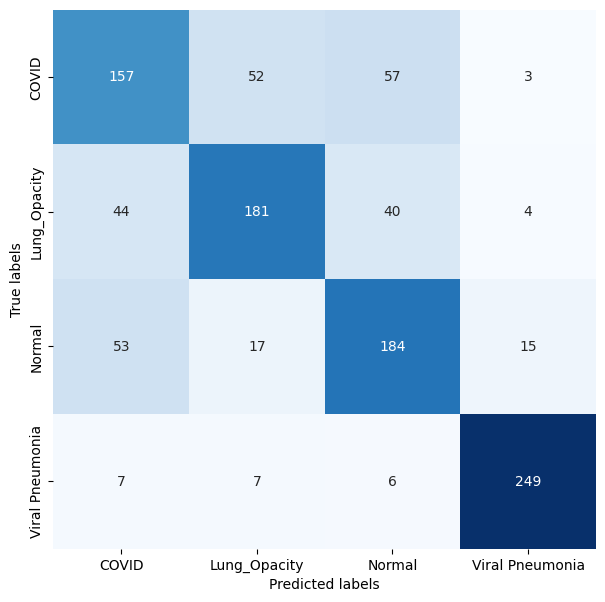

In [ ]:
model_name = "XGBost_TEST_classifier_method"
# show and save confusion matrix with absolute values: 
create_cm(y_test, y_pred, None , model_path, model_name)

norma
true


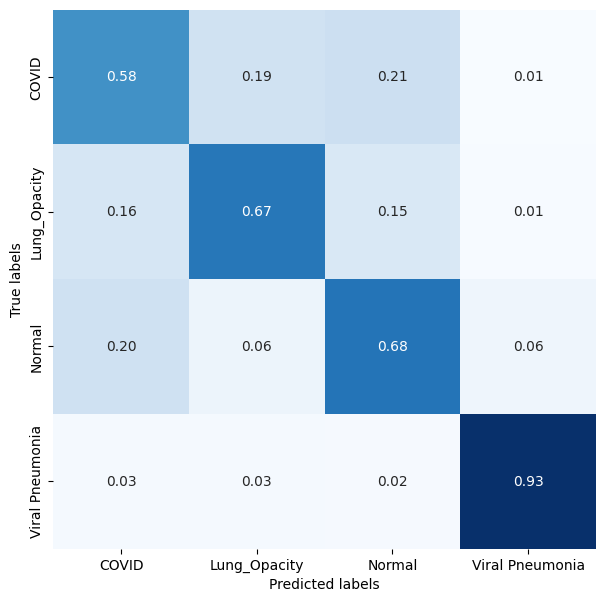

In [ ]:
# show and saveonfusion matrix with normalized values: 
create_cm(y_test, y_pred, 'true' , model_path, model_name)

## XGBoost Cross-Validation

In [ ]:
# if machine == 'colab':
#     params = {'booster': 'gbtree', "objective": "multi:softprob", "learning_rate": 0.3,  "tree_method": "gpu_hist", "num_class":4} # with gpu
# elif machine == 'local':
#     params = {'booster': 'gbtree', "objective": "multi:softprob", "learning_rate": 0.3, "tree_method": "hist", "num_class":4} # with cpu

# n = 1000

# results = xgb.cv(
#    params, 
#    m_train,
#    num_boost_round=n,
#    nfold=5,
#    metrics=["mlogloss", "auc", "merror"],
#    early_stopping_rounds=20
# )

# results.keys()
# results['test-auc-mean'].max()

0.8958161132875754

In [ ]:
# results.keys()

Index(['train-mlogloss-mean', 'train-mlogloss-std', 'train-auc-mean',
       'train-auc-std', 'train-merror-mean', 'train-merror-std',
       'test-mlogloss-mean', 'test-mlogloss-std', 'test-auc-mean',
       'test-auc-std', 'test-merror-mean', 'test-merror-std'],
      dtype='object')

In [ ]:
# results_filename = "results_CV_" + model_name + ".csv"
# results.to_csv(os.path.join(model_path, results_filename))

In [ ]:
# # create filename of saved model:
# if flag_slicing == True:
#     model_name     = 'XGboost_' + flag_dataset + '_slice'+ str(num_subset) 
#     model_filename = model_name + '.joblib' 
# else: 
#     model_name     = 'XGBoost_' + flag_dataset
#     model_filename =  model_name + '.joblib'

In [ ]:
# model_name
# os.path.join(model_path, "results", model_name + "_cf_report.csv" )

'..\\\\Models\\\\local\\\\ML\\results\\XGBoost_128_no_aug_mask_cf_report.csv'

## Evaluation

In [ ]:
# # make predictions
# preds_proba = model.predict(m_test)
# preds = np.argmax(preds_proba, axis=1) # get class with max of probability and save it to preds vector

# accuracy = accuracy_score(y_test, preds)
# print(accuracy)
# #pd.crosstab(pd.Series(preds), pd.Series(y_test))

NameError: name 'm_test' is not defined

In [ ]:
# # classification report
# print(classification_report(y_test, preds))

# # save report
# report_xgb = classification_report(y_test, preds, output_dict=True)
# df_report_xgb = pd.DataFrame(report_xgb).transpose()
# df_report_xgb.to_csv(os.path.join(model_path, "results", model_name + "_cf_report.csv" ), index=True)


              precision    recall  f1-score   support

           0       0.64      0.61      0.62       269
           1       0.72      0.70      0.71       269
           2       0.67      0.72      0.69       269
           3       0.93      0.94      0.94       269

    accuracy                           0.74      1076
   macro avg       0.74      0.74      0.74      1076
weighted avg       0.74      0.74      0.74      1076



abs
None


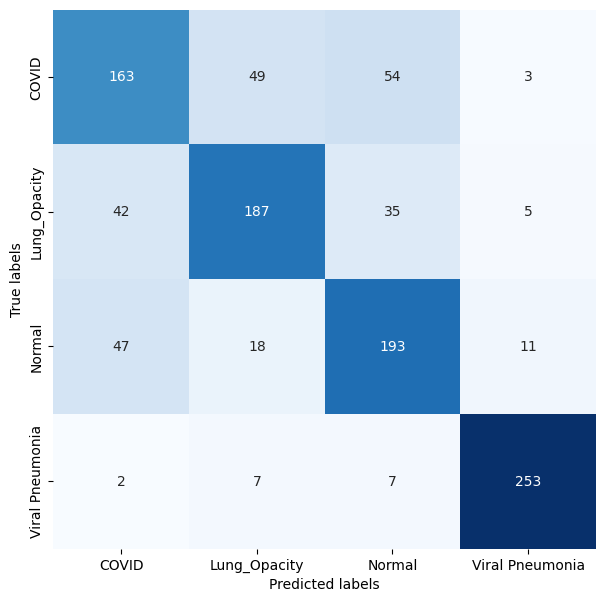

In [ ]:
# # show and save confusion matrix with absolute values: 
# create_cm(y_test, preds, None , model_path, model_name)

norma
true


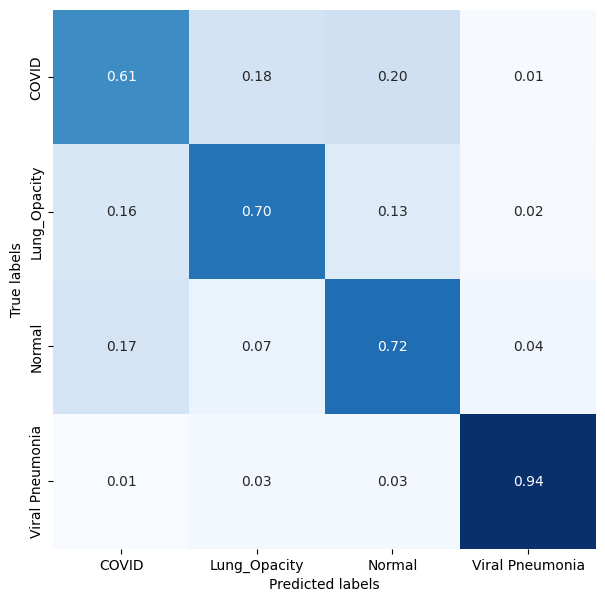

In [ ]:
# # show and saveonfusion matrix with normalized values: 
# create_cm(y_test, preds, 'true' , model_path, model_name)

### scaling - not used

In [ ]:
# # sacling the data
# scaler = StandardScaler()

# # fit and transform train data 
# X_train_scaled = scaler.fit_transform(X_train)

# # fit test data
# X_test_scaled = scaler.transform(X_test)

# scaling is not used because the standard-scaler scales along the columns and that means scaling over the same pixel in each image

# X_test_scaled = X_test
# X_train_scaled = X_train